In [6]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalNormalSimulator, MainSimulator
from src.python.helpers import n_clust_obs_v_v, get_preds_and_bfs
from src.python.visualization import compute_eces_variable, plot_eces_variable, plot_eces_means

import numpy as np
import pandas as pd
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up networks

In [7]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalNormalSimulator())

In [8]:
# Cosine Decay with Restarts

initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha
    )

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam, lr_schedule_restart),
    skip_checks=True
    )

In [9]:
n_clust_min = 1
n_clust_max = 100
n_obs_min = 1
n_obs_max = 100

# Train & validate

In [14]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=40, iterations_per_epoch=1000, batch_size=32, 
    n_obs=partial(n_clust_obs_v_v, n_clust_min, n_clust_max, n_obs_min, n_obs_max)
    )
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
# Validation

#n_val_per_setting = 5000
n_val_per_setting = 20

ece_means = compute_eces_variable(
    evidence_net, summary_net, simulator, 
    n_val_per_setting, n_clust_min, n_clust_max, 
    n_obs_min, n_obs_max
    )

Loop through clusters progress:   0%|          | 0/100 [00:00<?, ?it/s]

Loop through nested observations progress:   0%|          | 0/100 [00:00<?, ?it/s]

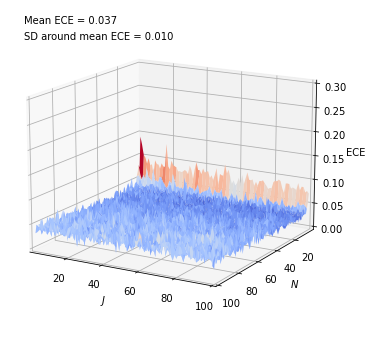

In [7]:
# Plot ECEs

plot_eces_variable(ece_means, n_clust_min, n_clust_max, n_obs_min, n_obs_max)

[0.03818835 0.03954217 0.03752209 0.03728921 0.03796554]


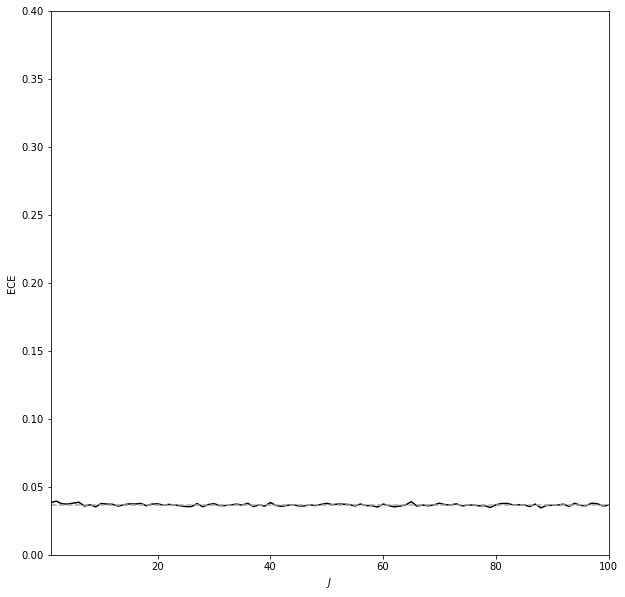

In [8]:
# Plot ECEs for diffent J's (averaged over N)
x_axis = 0
plot_eces_means(ece_means, n_clust_min, n_clust_max, n_obs_min, n_obs_max, x_axis)

[0.08246688 0.05526787 0.04631376 0.03857674 0.03601969]


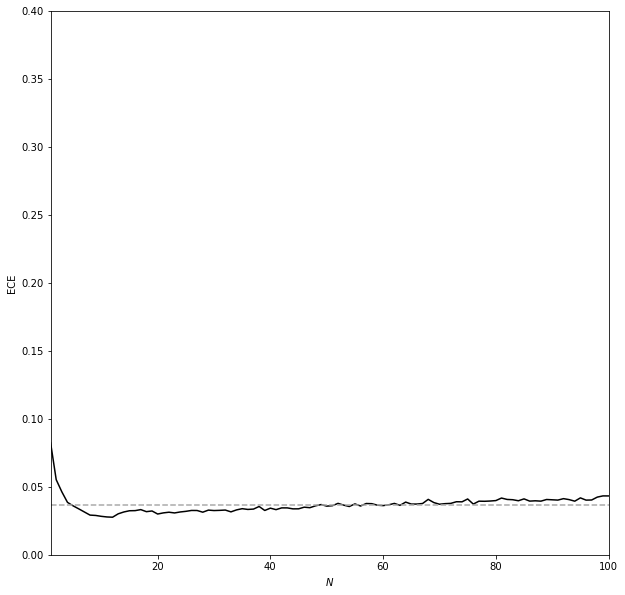

In [6]:
# Plot ECEs for diffent N's (averaged over J)
plot_eces_means(ece_means, n_clust_min, n_clust_max, n_obs_min, n_obs_max, x_axis=1)

In [ ]:
# Export ECE data
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_variable_clusters_variable_obs_eces_n_obs')
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', 'Validation_datasets')
np.save(os.path.join(val_folder, filename), ece_means)

In [5]:
# Load ECE data
n_val_per_setting = 5000

n_clust_min = 1
n_clust_max = 100
n_obs_min = 1
n_obs_max = 100

val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', 'Validation_datasets')
ece_filename = "2022_03_18___14_19_variable_clusters_variable_obs_eces.npy"
ece_means = np.load(os.path.join(val_folder, ece_filename))

# Calculate Bayes factors for bridge sampling comparison

In [11]:
val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', 'BF_approximation_comparison')
data_filename = "test_data_bf.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [15]:
comparison_results = get_preds_and_bfs(evidence_net, summary_net, test_data, training_time_start, training_time_stop, losses)
#comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.876492,0.123508,0,0.140912,31.579011,0.017786,0.375259
1,2,1,0.254320,0.745680,1,2.932060,31.579011,0.017786,0.375259
2,3,1,0.156089,0.843911,1,5.406618,31.579011,0.017786,0.375259
3,4,1,0.466228,0.533772,1,1.144873,31.579011,0.017786,0.375259
4,5,0,0.875140,0.124860,0,0.142674,31.579011,0.017786,0.375259


In [ ]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_BF_NN_variable_comp')
comparison_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'BF_approximation_comparison')

comparison_results.to_csv(os.path.join(comparison_folder, filename), index = False)